In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
data = pd.read_excel('1995cohort (1).xlsx',index_col=0)

In [3]:
traindata = data.iloc[:,1:7]

In [4]:
freqency = traindata.sum(axis=1)

In [5]:
recency = traindata.T.iloc[::-1].cumsum().apply(pd.Series.value_counts).loc[0,:]

In [6]:
recency.fillna(0,inplace=True)

In [7]:
train2data = traindata.copy()
train2data['frequency'] = freqency
train2data['recency']=6-recency

In [8]:
samples = train2data.groupby(['frequency','recency']).frequency.count()

# Parameter estimation

In [9]:
from scipy.special import beta as B

In [10]:
samples.name = 'samples'
samples = samples.reset_index()

In [11]:
alpha = beta = gamma = delta =  1

In [12]:
def objfunc(df):
    def function(args):
        import math
        alpha,beta,gamma,delta = args[0],args[1],args[2],args[3]
        ll = 0
        for x,tx,number in df.values:
            part1=B(alpha+x,beta+6-x)/B(alpha,beta)*(B(gamma,delta+6))/(B(gamma,delta))
            part2=0
            #print('{:.5f}'.format(part1),end='\t')
            for i in range(6-1-tx+1):
                part20=B(alpha+x,beta+tx-x+i)/B(alpha,beta)*(B(gamma+1,delta+i+tx))/(B(gamma,delta))
                #print('{:.5f}'.format(part20),end='\t')
                part2+=part20
            l = part1+part2
            
            ll+=number*math.log10(l)
            #print(x,tx,number,math.log(l)*number)
        return -ll
    return function

In [13]:
from scipy.optimize import minimize
res = minimize(objfunc(samples.astype(int)),np.array((1,0.5,0.5,2)),method='BFGS')

In [14]:
res.x

array([1.20351605, 0.74971479, 0.656726  , 2.78349058])

In [15]:
objfunc(samples.astype(int))((1,0.7,0.6,2.7))

14435.642553367423

In [16]:
alpha,beta,gamma,delta = res.x

# Evaluation

## In-sample fit

In [17]:
from scipy.special import comb, perm

In [18]:
def func(x):
    n=6
    part1 = comb(6,x)*(B(alpha+x,beta+n-x))/(B(alpha,beta))*(B(gamma,delta+n))/B(gamma,delta)
    part2 = 0
    for i in range(x,n-1+1):
        part2+=comb(i,x)*(B(alpha+x,beta+i-x))/(B(alpha,beta))*(B(gamma+1,delta+i))/B(gamma,delta)
    return part1+part2

In [19]:
model_freq = list(range(7))

In [20]:
model_freq = np.array(list(map(func,model_freq)))

In [21]:
model_fit = model_freq*len(data)
actual_data = train2data.groupby('frequency').recency.count().values

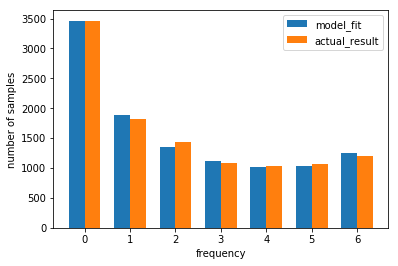

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots()
p1 = ax.bar(np.arange(7), model_fit,0.35,label='model_fit')
p1 = ax.bar(np.arange(7)+0.35, actual_data,0.35,label='actual_result')

ax.set_ylabel('number of samples')
ax.set_xlabel('frequency')
ax.set_xticklabels(np.arange(7).astype(str))
_ = ax.set_xticks(np.arange(7) + 0.35 / 2)
ax.legend()

## Tracking plots
- The average number of times a donor will donate in n years.

In [25]:
from scipy.special import gamma as G

In [26]:
def efun(n):
    return alpha/(alpha+beta)*delta/(gamma-1)*(1-(G(gamma+delta))/G(gamma+delta+n)*G(1+delta+n)/G(1+delta))
    

In [55]:
model_tracking=pd.Series(efun(np.arange(1,12)))
model_tracking=(model_tracking*len(data)).diff().fillna(model_tracking.iloc[0]*len(data))

In [56]:
actual_tracking=data.iloc[:,1:].sum().values

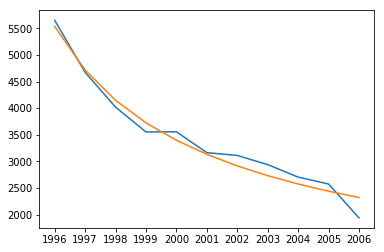

In [59]:
plt.plot(actual_tracking)
plt.plot(model_tracking)
_=plt.xticks(np.arange(len(actual_tracking)),data.columns[1:])

## Conditional expectations

### Insample table

In [63]:
samples.pivot('frequency','recency','samples')

recency,0.0,1.0,2.0,3.0,4.0,5.0,6.0
frequency,,,,,,,
0,3464.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1091.0,277.0,129.0,78.0,119.0,129.0
2,NaN,NaN,613.0,255.0,155.0,173.0,234.0
3,NaN,NaN,NaN,322.0,181.0,225.0,357.0
4,NaN,NaN,NaN,NaN,240.0,284.0,512.0
5,NaN,NaN,NaN,NaN,NaN,335.0,728.0
6,NaN,NaN,NaN,NaN,NaN,NaN,1203.0


### out of sample actual

In [76]:
testdata = data.iloc[:,-5:].copy()

In [77]:
testdata['freq_test']=testdata.sum(axis=1)

In [78]:
testdata['frequncy'] = freqency
testdata['recency'] = 6-recency

In [79]:
testdata.groupby(['frequncy','recency']).freq_test.sum().unstack()

recency,0.0,1.0,2.0,3.0,4.0,5.0,6.0
frequncy,,,,,,,
0,604.0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,238.0,103.0,78.0,44.0,136.0,190.0
2,NaN,NaN,244.0,118.0,114.0,244.0,442.0
3,NaN,NaN,NaN,148.0,170.0,373.0,817.0
4,NaN,NaN,NaN,NaN,201.0,542.0,1393.0
5,NaN,NaN,NaN,NaN,NaN,582.0,2227.0
6,NaN,NaN,NaN,NaN,NaN,NaN,4252.0


### predict result

In [85]:
def likelihood(x,tx):
    part1=B(alpha+x,beta+6-x)/B(alpha,beta)*(B(gamma,delta+6))/(B(gamma,delta))
    part2=0
    #print('{:.5f}'.format(part1),end='\t')
    for i in range(6-1-tx+1):
        part20=B(alpha+x,beta+tx-x+i)/B(alpha,beta)*(B(gamma+1,delta+i+tx))/(B(gamma,delta))
        #print('{:.5f}'.format(part20),end='\t')
        part2+=part20
    l = part1+part2
    return l

In [87]:
def expectation(n,nstar):
    return B(alpha+x+1,beta+n-x)/B(alpha,beta)*delta/(gamma-1)*G(gamma+delta)/G(1+delta)*(G(1+delta+n)/G(gamma+delta+n)-G(1+delta+n+nstar)/G(gamma+delta+n+nstar))

In [98]:
test_samples = testdata.groupby(['frequncy','recency']).freq_test.count().reset_index()

In [106]:
result=[]
for x,tx,number in test_samples.astype(int).values:
    result.append([x,tx,expectation(6,5)/likelihood(x,tx)*number])

In [109]:
df = pd.DataFrame(result,columns=['x','tx','prediction'])
df.pivot('x','tx','prediction')

tx,0,1,2,3,4,5,6
x,,,,,,,
0,252.399337,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,93.493985,87.043668,76.606744,65.472628,121.580547,148.076701
2,NaN,NaN,73.020857,136.707689,163.927940,249.645582,390.502271
3,NaN,NaN,NaN,71.997076,187.256697,406.057087,781.738909
4,NaN,NaN,NaN,NaN,139.965249,576.525189,1387.866399
5,NaN,NaN,NaN,NaN,NaN,607.333090,2352.610828
6,NaN,NaN,NaN,NaN,NaN,NaN,4514.305620
